In [1]:
import os
import sys

import matplotlib.pyplot as plt
from hydra import initialize, compose
from glob import glob
import pickle
import numpy as np

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses import lens_util
from mejiro.plots import plot
from mejiro.utils import util
from mejiro.helpers import color

In [2]:
side = 10

In [3]:
pandeia_dir = os.path.join(array_dir, '04_pandeia_output_color')
pandeia_files = glob(pandeia_dir + '/pandeia_*')[:side ** 2]
pandeia_images = [np.load(i) for i in pandeia_files]

In [4]:
color_pandeia_images = []

for i in range(side ** 2):
    all_filters = glob(pandeia_dir + f'/pandeia_{str(i).zfill(8)}_*.npy')
    # print(all_filters)
    f106 = [np.load(i) for i in all_filters if 'f106' in i][0]
    f129 = [np.load(i) for i in all_filters if 'f129' in i][0]
    f158 = [np.load(i) for i in all_filters if 'f158' in i][0]
    f184 = [np.load(i) for i in all_filters if 'f184' in i][0]
    if f106.shape == (91, 91):
        color_image = color.get_rgb(image_b=f106, image_g=f129, image_r=f184)
        color_pandeia_images.append(color_image)

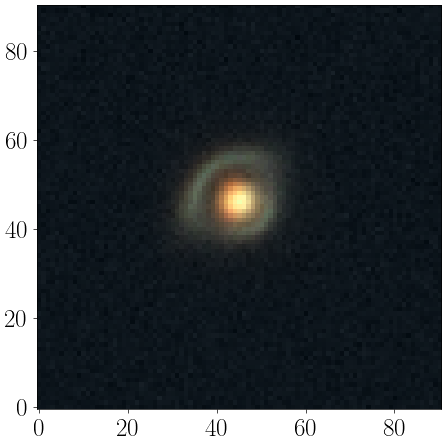

In [5]:
plot.plot(color_pandeia_images[35])

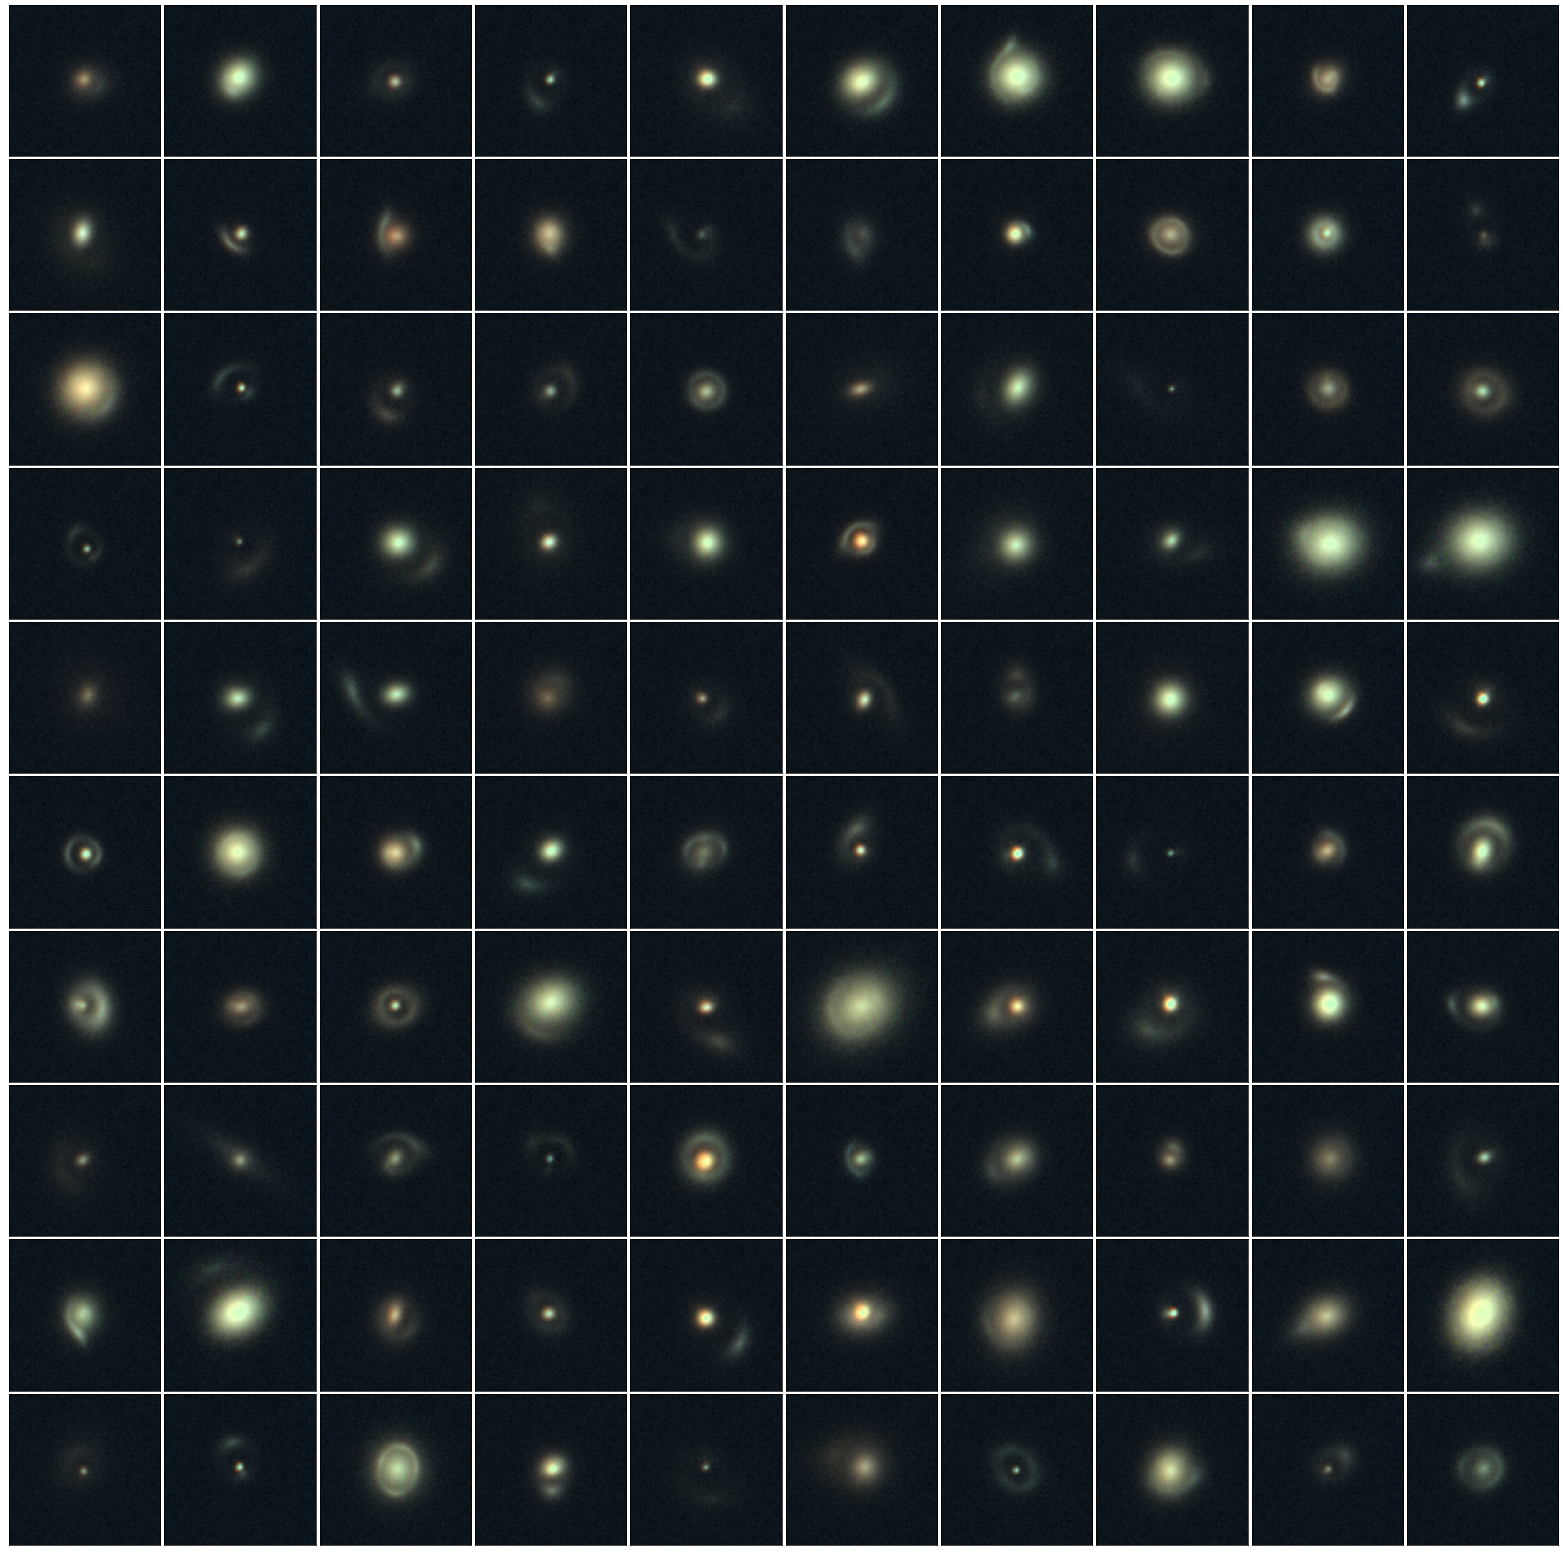

In [6]:
save_path = os.path.join(figure_dir, 'mosaic_pandeia.png')
plot.plot_grid(color_pandeia_images, side=side, log10=False, save=save_path)

In [7]:
dict_file_list = glob(os.path.join(pickle_dir, '03_models_and_updated_lenses') + '/*')

pickle_list = []
for i in range(side ** 2):
    pickled = [file for file in dict_file_list if f'lens_dict_{str(i).zfill(8)}_f106' in file][0]
    pickle_list.append(pickled)

dict_list = [util.unpickle(pickled) for pickled in pickle_list]
model_list = [i['model'] for i in dict_list]

In [8]:
color_model_images = []
basepath = os.path.join(pickle_dir, '03_models_and_updated_lenses')

for i in range(side ** 2):
    all_filter_pickles = glob(basepath + f'/lens_dict_{str(i).zfill(8)}_*')
    f106 = [util.unpickle(i) for i in all_filter_pickles if 'f106' in i][0]
    f129 = [util.unpickle(i) for i in all_filter_pickles if 'f129' in i][0]
    f158 = [util.unpickle(i) for i in all_filter_pickles if 'f158' in i][0]
    f184 = [util.unpickle(i) for i in all_filter_pickles if 'f184' in i][0]
    f106_model = f106['model']
    f129_model = f129['model']
    f158_model = f158['model']
    f184_model = f184['model']
    color_image = color.get_rgb(image_b=f106_model, image_g=f129_model, image_r=f184_model)
    color_model_images.append(color_image)

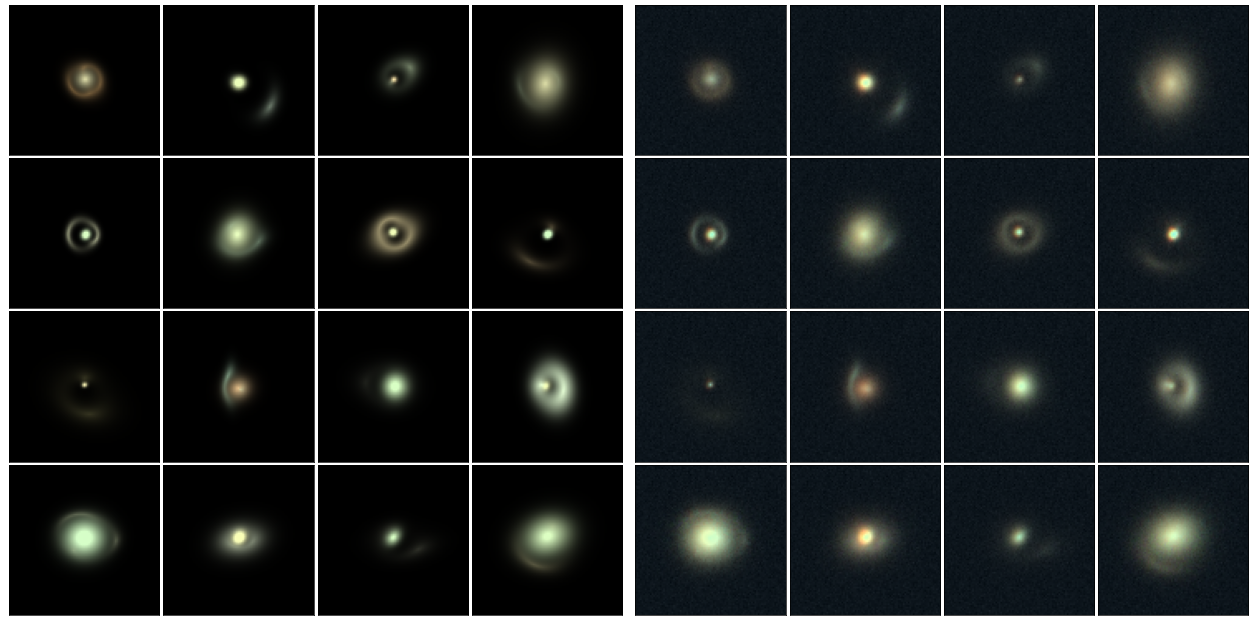

In [12]:
fig = plt.figure(figsize=(16, 16))
outer_grid = fig.add_gridspec(2, 2, wspace=0.02, hspace=0.02)

grid = 4

import random
np.random.seed(config.seed)
random_indices = random.sample(range(len(pandeia_images)), grid ** 2)

model_subset = [color_model_images[i] for i in random_indices]
pandeia_subset = [color_pandeia_images[i] for i in random_indices]

subsets = [model_subset, pandeia_subset]

for i, subset in enumerate(subsets):
    inner_grid = outer_grid[0, i].subgridspec(4, 4, wspace=0.02, hspace=0.02)
    ax = inner_grid.subplots()
    for i, image in enumerate(subset):
        ax[i // grid, i % grid].imshow(image, cmap='viridis')
        ax[i // grid, i % grid].get_xaxis().set_visible(False)
        ax[i // grid, i % grid].get_yaxis().set_visible(False)

plt.savefig(os.path.join(figure_dir, 'mosaic.png'))
plt.show()